# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import re
import spacy


import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, classification_report
import nltk
from transformers import BertModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from lightgbm import LGBMClassifier
import joblib

import torch
import transformers

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
#importamos los datos.
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Mostramos las primeras filas para verificar que los datos se hayan cargado correctamente
display(df_reviews.head())

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
# Revisamos la estructura y los tipos de datos del DataFrame
display(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

None

In [7]:
def clean_dataframe(df):
    """
    Limpia y revisa un DataFrame para verificar duplicados, valores nulos y otros problemas comunes.
    
    Args:
    - df (pd.DataFrame): DataFrame a limpiar y revisar.
    
    Returns:
    - pd.DataFrame: DataFrame revisado.
    """
    print("Resumen del DataFrame:")
    print(df.info())
    
    # Verificar duplicados
    duplicate_count = df.duplicated().sum()
    print(f"\nNúmero de filas duplicadas: {duplicate_count}")
    
    if duplicate_count > 0:
        df = df.drop_duplicates()
        print("Duplicados eliminados.")
    
    # Verificar valores nulos
    null_summary = df.isnull().sum()
    print("\nNúmero de valores nulos por columna:")
    print(null_summary[null_summary > 0])
    
    # Reportar valores nulos pero no eliminarlos
    if null_summary.any():
        print("\nConsidera cómo manejar los valores nulos en las siguientes columnas:")
        print(null_summary[null_summary > 0])
        print("Posibles acciones incluyen rellenar valores nulos con una estrategia apropiada o mantenerlos para análisis posterior.")
    
    print("\nDatos revisados:")
    print(df.info())
    
    return df

In [8]:
df_reviews = clean_dataframe(df_reviews)

Resumen del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  in

In [9]:
# Eliminar filas con valores nulos
df_reviews = df_reviews.dropna()

print("DataFrame después de eliminar valores nulos:")
print(df_reviews.info())

DataFrame después de eliminar valores nulos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx          

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

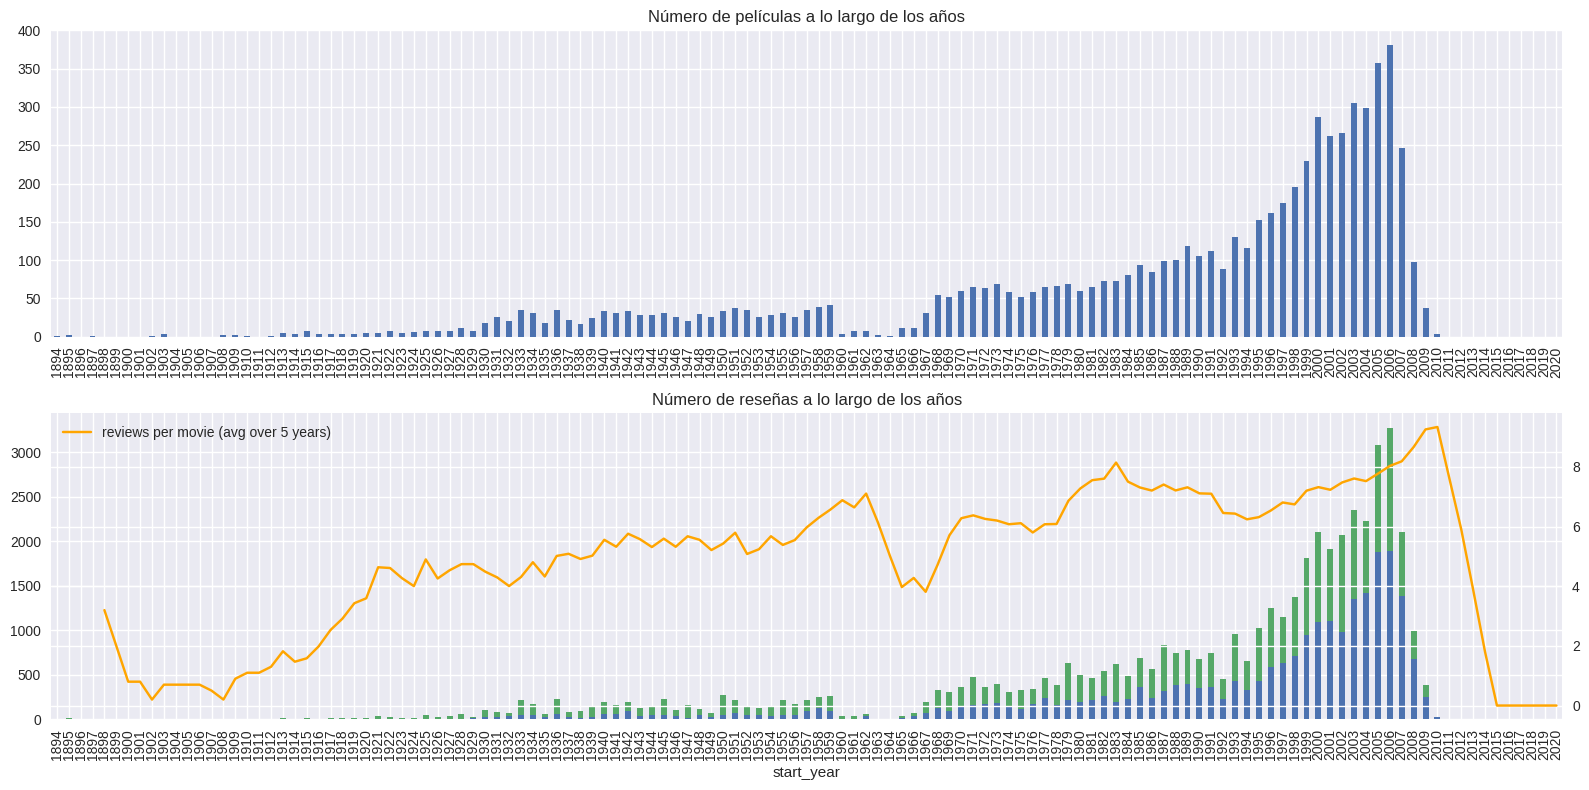

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

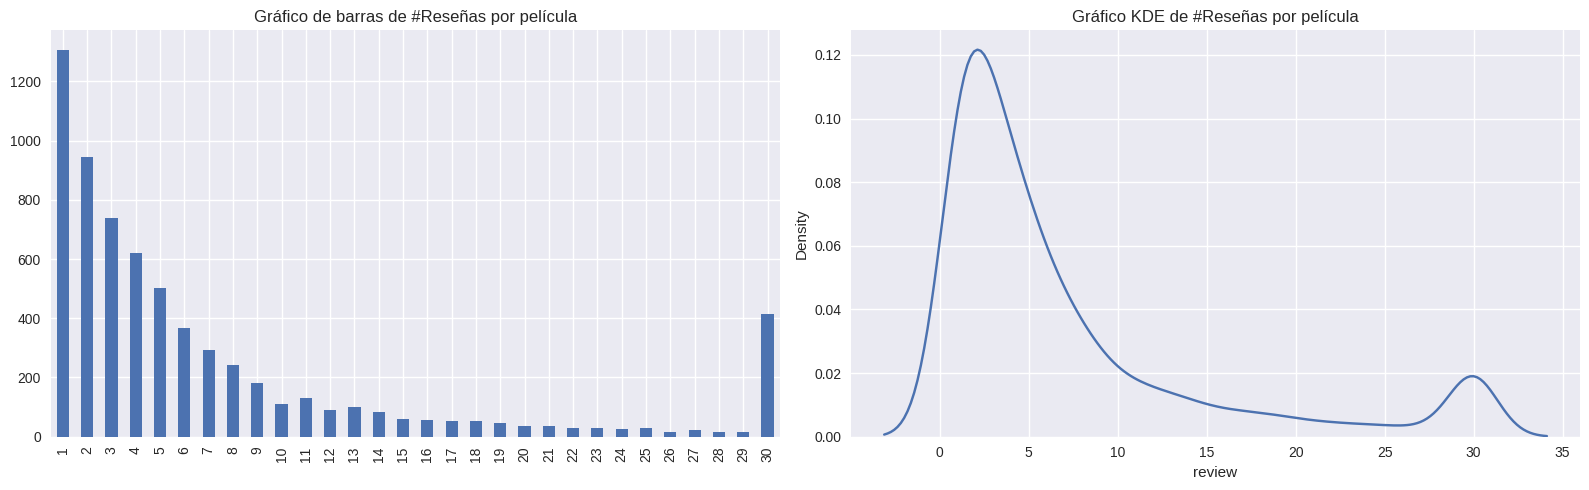

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

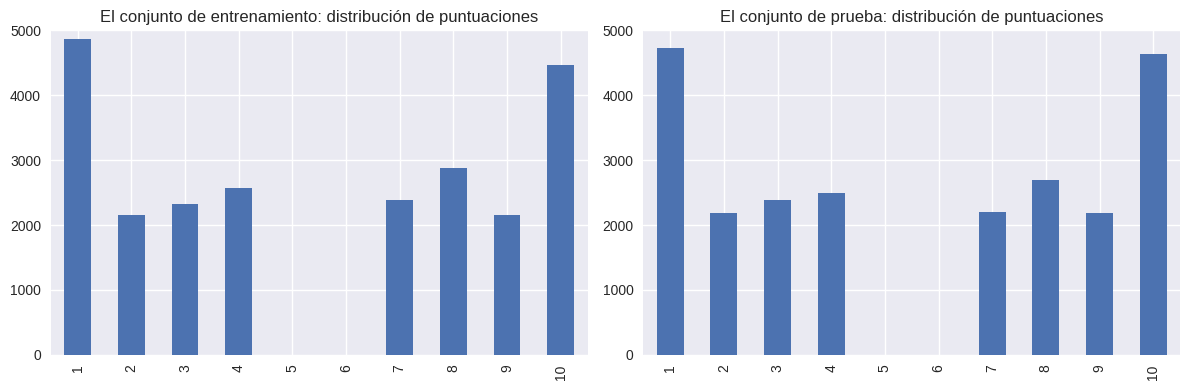

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

### Análisis del Desequilibrio de Clases

- Aumento de Reseñas a lo Largo de los Años:

 Observamos un incremento significativo en el número de reseñas hasta alcanzar un pico en 2007.
 Este aumento puede deberse a una mayor popularidad del producto o servicio, una mayor confianza de los consumidores en las plataformas de reseñas, o campañas de marketing que incentivaron a los usuarios a dejar sus opiniones.
 
La caída abrupta en el número de reseñas después de 2007, hasta desaparecer completamente en 2011, sugiere un cambio drástico en la dinámica del mercado o en el comportamiento del consumidor. Esto podría estar relacionado con factores externos como la entrada de competidores, cambios en la política de la empresa, o incluso una disminución en la relevancia del producto.

- Comparación entre Conjunto de Entrenamiento y Conjunto de Prueba:

 El hecho de que las gráficas del conjunto de entrenamiento y del conjunto de prueba sean muy similares indica que la distribución temporal de las reseñas ha sido bien preservada al dividir los datos. Esto es positivo, ya que asegura que el modelo entrenado no se sesgará por diferencias significativas entre el entrenamiento y la prueba.
 
Sin embargo, si ambos conjuntos reflejan la misma caída abrupta en las reseñas después de 2007, esto podría limitar la capacidad del modelo para generalizar sobre reseñas más recientes o futuras.

- Distribución de Puntuaciones Positivas y Negativas:

 La distribución pareja entre puntuaciones positivas y negativas es un buen indicio de que no existe un fuerte desequilibrio de clases en términos de polaridad de las reseñas. Esto es crucial, ya que un desequilibrio significativo podría causar que el modelo sea sesgado hacia la clase mayoritaria, afectando la precisión de las predicciones.

- Conclusion:

 El análisis muestra un comportamiento temporal complejo en la distribución de reseñas, con un incremento hasta 2007 seguido de una caída abrupta y desaparición hasta 2011. La similitud entre los conjuntos de entrenamiento y prueba en términos de distribución temporal es un aspecto positivo, asegurando que el modelo no esté sesgado por diferencias significativas entre los conjuntos. La distribución pareja entre reseñas positivas y negativas indica una buena representación de ambas clases, minimizando el riesgo de desequilibrio.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


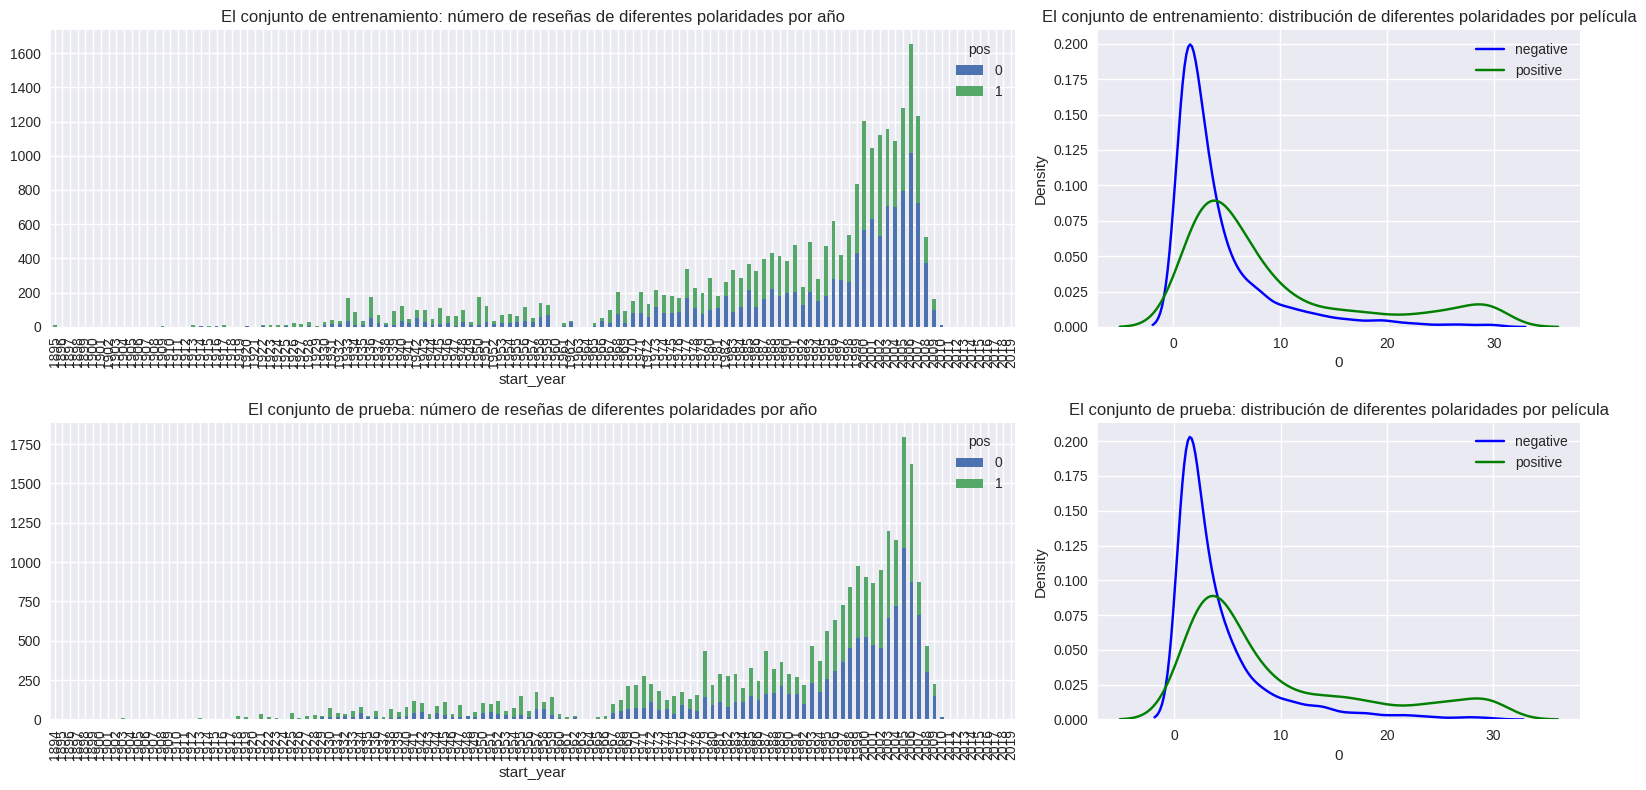

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [15]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [16]:
# Convertir a numpy arrays antes de llamar a evaluate_model
def convert_to_numpy(*args):
    return [arg.to_numpy() if isinstance(arg, pd.Series) else np.array(arg) for arg in args]

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
# Función para normalizar el texto
def normalize_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar dígitos
    text = re.sub(r'\d+', '', text)
    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Aplicar la función de normalización a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [18]:
#Chequeamos la columna "review_norm"
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um  a serious film about troubled teens in sin...
4        im totally agree with garryjohal from singapor...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_norm, Length: 47329, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabajar con modelos

### Modelo 0 - Constante

El modelo constante es un modelo básico que sirve como punto de referencia. Utilizamos DummyClassifier para hacer predicciones que no dependen de los datos de entrada, sino que simplemente predicen una constante.

               Exactitud   F1  APS  ROC AUC
Entrenamiento        0.5  0.0    0        0
Prueba               0.5  0.0    0        0


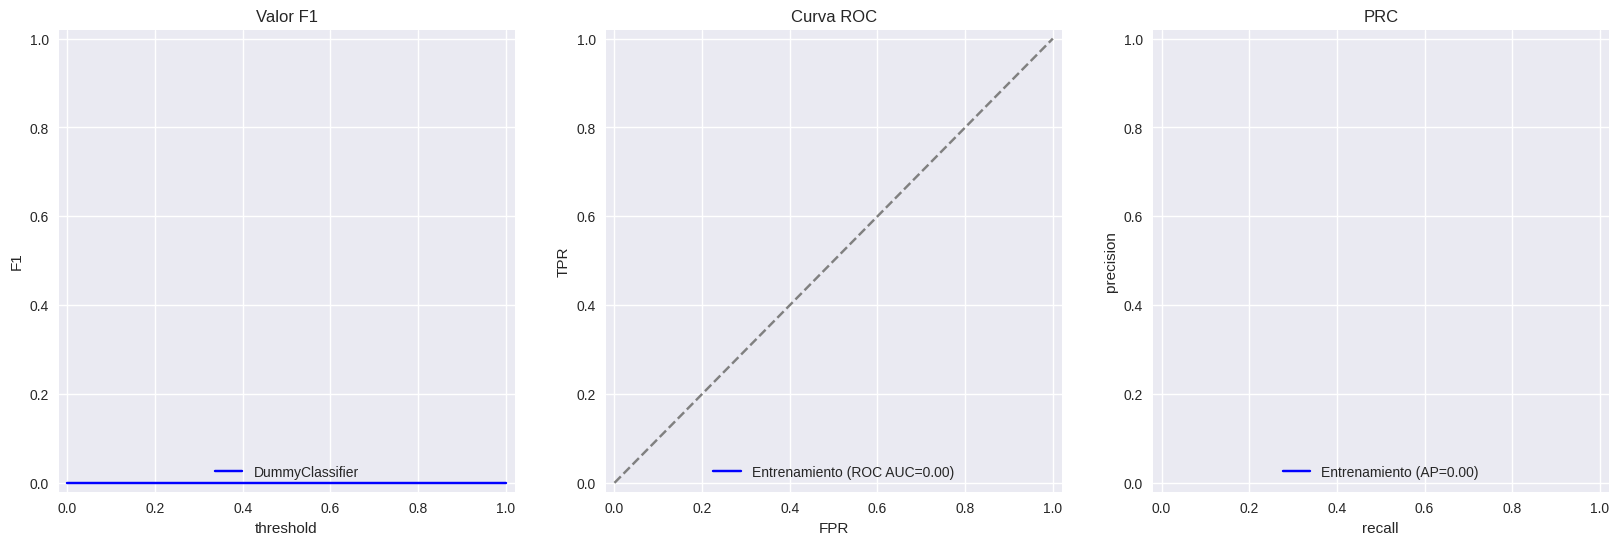

In [20]:
# Entrenar el DummyClassifier
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(df_reviews_train[['review_norm']], train_target)

# Predicciones
train_pred_target = dummy_model.predict(df_reviews_train[['review_norm']])
test_pred_target = dummy_model.predict(df_reviews_test[['review_norm']])

# Evaluación en el conjunto de entrenamiento
train_pred_proba = np.zeros_like(train_pred_target)  # DummyClassifier no tiene predict_proba
train_fpr, train_tpr, train_roc_thresholds = [0], [0], [0]  # Valores por defecto
train_precision, train_recall, train_pr_thresholds = [0], [0], [0]
train_roc_auc = 0
train_aps = 0

# Evaluación en el conjunto de prueba
test_pred_proba = np.zeros_like(test_pred_target)  # DummyClassifier no tiene predict_proba
test_fpr, test_tpr, test_roc_thresholds = [0], [0], [0]  # Valores por defecto
test_precision, test_recall, test_pr_thresholds = [0], [0], [0]
test_roc_auc = 0
test_aps = 0

# Calcular métricas
train_accuracy = metrics.accuracy_score(train_target, train_pred_target)
test_accuracy = metrics.accuracy_score(test_target, test_pred_target)

train_f1 = metrics.f1_score(train_target, train_pred_target, average='binary')
test_f1 = metrics.f1_score(test_target, test_pred_target, average='binary')

# Crear un DataFrame para mostrar las métricas
df_eval_stats = pd.DataFrame({
    'Exactitud': [train_accuracy, test_accuracy],
    'F1': [train_f1, test_f1],
    'APS': [train_aps, test_aps],
    'ROC AUC': [train_roc_auc, test_roc_auc]
}, index=['Entrenamiento', 'Prueba'])

df_eval_stats = df_eval_stats.round(2)
print(df_eval_stats)

# Graficar las métricas
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# F1 Score
f1_thresholds = np.arange(0, 1.01, 0.05)
axs[0].plot(f1_thresholds, np.zeros_like(f1_thresholds), color='blue', label='DummyClassifier')
axs[0].set_xlim([-0.02, 1.02])
axs[0].set_ylim([-0.02, 1.02])
axs[0].set_xlabel('threshold')
axs[0].set_ylabel('F1')
axs[0].legend(loc='lower center')
axs[0].set_title('Valor F1')

# ROC Curve
axs[1].plot(train_fpr, train_tpr, color='blue', label='Entrenamiento (ROC AUC=0.00)')
axs[1].plot([0, 1], [0, 1], color='grey', linestyle='--')
axs[1].set_xlim([-0.02, 1.02])
axs[1].set_ylim([-0.02, 1.02])
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].legend(loc='lower center')
axs[1].set_title('Curva ROC')

# PRC Curve
axs[2].plot(train_recall, train_precision, color='blue', label='Entrenamiento (AP=0.00)')
axs[2].set_xlim([-0.02, 1.02])
axs[2].set_ylim([-0.02, 1.02])
axs[2].set_xlabel('recall')
axs[2].set_ylabel('precision')
axs[2].legend(loc='lower center')
axs[2].set_title('PRC')

plt.show()


La función evaluate_model que han proporcionado está diseñada para evaluar modelos de clasificación que ofrecen probabilidades de predicción (predict_proba) y permiten un ajuste de umbral de decisión. El DummyClassifier de sklearn tiene limitaciones que impiden el uso directo de esta función para su evaluación.

Sin embargo se han tomado sus metricas para la evaluacion de este modelo.

Los gráficos están en cero y vacíos porque el DummyClassifier con la estrategia most_frequent siempre predice la clase más común del conjunto de datos, sin considerar ninguna característica del mismo. Esto significa que no hay variabilidad en las predicciones: todas las instancias se clasifican de la misma manera. Como resultado:

1. Curva ROC y ROC AUC: No se puede trazar una curva ROC significativa porque no hay verdaderos positivos ni falsos positivos que varíen; el clasificador no está "aprendiendo" nada, solo devuelve una constante. Por tanto, tanto la tasa de verdaderos positivos (TPR) como la tasa de falsos positivos (FPR) son 0, y el área bajo la curva (ROC AUC) es 0.0.

2. Curva PRC (Precision-Recall Curve): De manera similar, no se puede calcular una curva de precisión-recall (PRC) significativa porque no hay variación en precisión y recall. La precisión y el recall son constantes porque todas las predicciones son iguales y no hay un rango de umbrales que evaluar.


Se eligen ceros como valores por defecto para estas métricas porque reflejan adecuadamente la falta de variabilidad y capacidad de clasificación del DummyClassifier. Los ceros sirven como inicializaciones prácticas que evitan errores y representan correctamente que el modelo no tiene poder predictivo real: simplemente está adivinando la clase más frecuente sin realizar ninguna clasificación basada en los datos.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [21]:
# Descargar stopwords de NLTK
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Configurar el TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, lowercase=True)

# Transformar las características textuales
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

In [23]:
# Inicializar y entrenar el modelo de regresión logística
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, train_target)

# Guardar el modelo entrenado
joblib.dump(model_1, 'model_1.pkl')

# Guardar el vectorizador TF-IDF
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


# Realizar predicciones
train_predictions_1 = model_1.predict(train_features_1)
test_predictions_1 = model_1.predict(test_features_1)
train_predictions_proba_1 = model_1.predict_proba(train_features_1)[:, 1]
test_predictions_proba_1 = model_1.predict_proba(test_features_1)[:, 1]

In [24]:
# Convertir los datos
train_target_array, test_target_array, train_predictions_array, test_predictions_array = convert_to_numpy(
    train_target, test_target, train_predictions_1, test_predictions_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


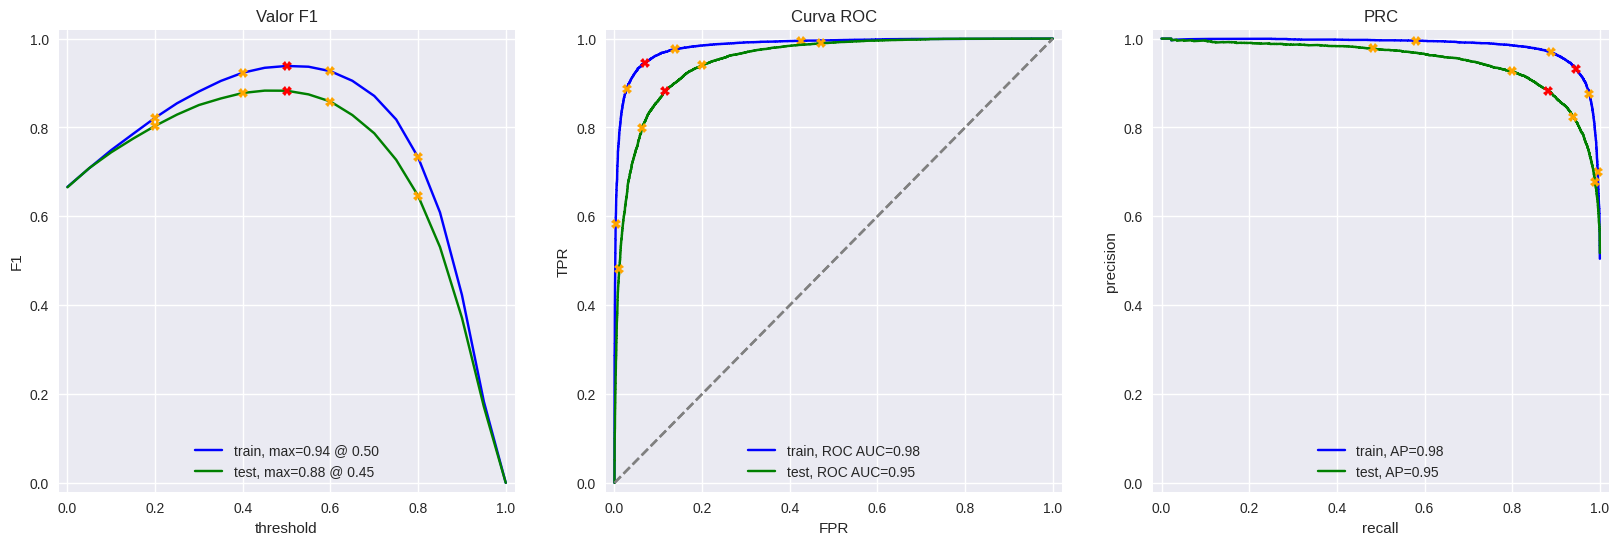

In [25]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [26]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [28]:
# Aplicar el preprocesamiento
df_reviews_train['processed_review'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['processed_review'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)


In [29]:
# Configurar el TF-IDF Vectorizer
tfidf_vectorizer_3 = TfidfVectorizer()

In [30]:
# Transformar las características textuales
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['processed_review'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['processed_review'])

In [31]:
# Inicializar y entrenar el modelo de regresión logística
model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, train_target)

# Realizar predicciones
train_predictions_3 = model_3.predict(train_features_3)
test_predictions_3 = model_3.predict(test_features_3)
train_predictions_proba_3 = model_3.predict_proba(train_features_3)[:, 1]
test_predictions_proba_3 = model_3.predict_proba(test_features_3)[:, 1]


# Guardar el modelo
joblib.dump(model_3, 'model_3.pkl')

# Guardar el vectorizador TF-IDF
joblib.dump(tfidf_vectorizer_3, 'tfidf_vectorizer_3.pkl')

['tfidf_vectorizer_3.pkl']

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


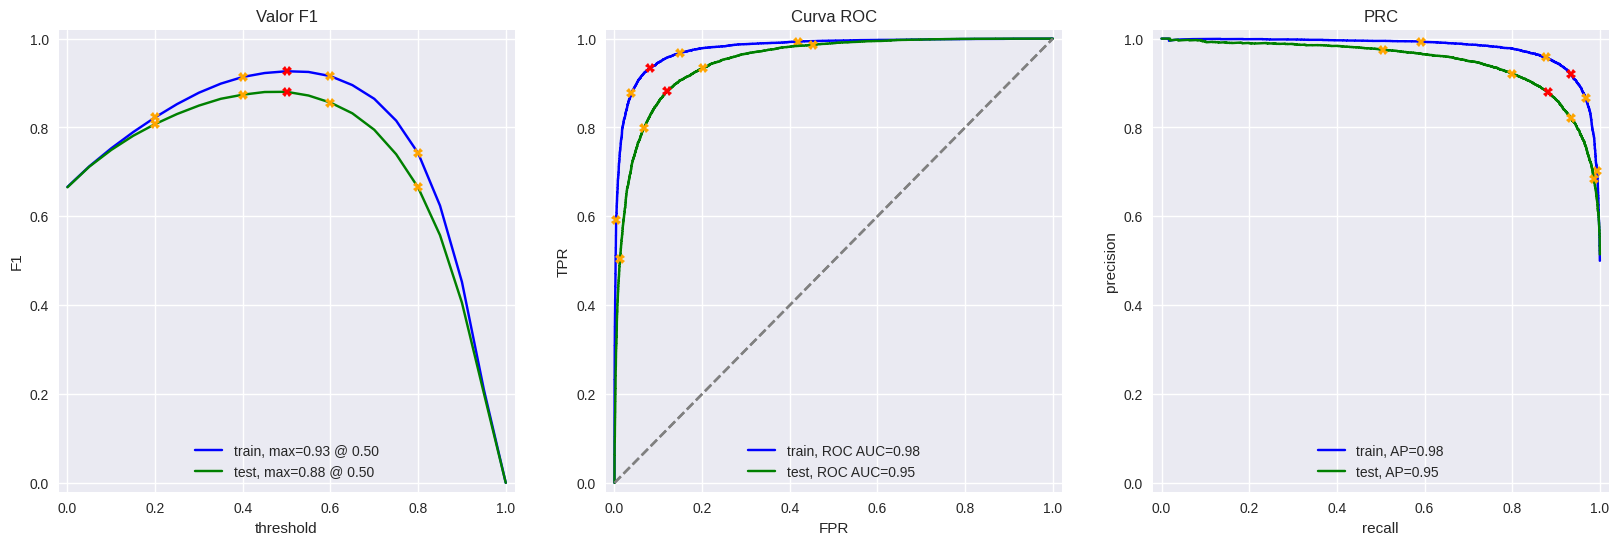

In [32]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)


En este punto luego de evaluar dos modelos diferentes y ver que en ambos obteniamos el mismo error nos enfocamos en chequear la funcion "evaluate_model" ya que nos daba NaN en la exactitud.

Y luego de ser revisada nos percatamos de que efectivamente tenia un pequeño error porque los nombres de las métricas en el diccionario eval_stats y el índice del DataFrame df_eval_stats deben coincidir.

Ahora esto ha sido corregido y se han nombrado "Accuracy" ambas.

Esto ha resuelto el problema y se puede obtener la exactitud sin ningun problema.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [33]:
#Función de Preprocesamiento para el Modelo 4

def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)


In [34]:
# Aplicar el preprocesamiento de texto al dataset

df_reviews_train['processed_text_4'] = df_reviews_train['review'].apply(text_preprocessing_4)
df_reviews_test['processed_text_4'] = df_reviews_test['review'].apply(text_preprocessing_4)


In [35]:
# Inicializa el vectorizador TF-IDF con configuración por defecto
tfidf_4 = TfidfVectorizer()

# Ajusta y transforma los datos de texto preprocesado para el entrenamiento
train_features_4 = tfidf_4.fit_transform(df_reviews_train['processed_text_4'])

# Transforma los datos de texto preprocesado para la prueba
test_features_4 = tfidf_4.transform(df_reviews_test['processed_text_4'])


In [36]:
#Definir y Entrenar el Modelo LGBMClassifier

# Inicializa LGBMClassifier con parámetros por defecto
model_4 = LGBMClassifier()

# Entrena el modelo
model_4.fit(train_features_4, train_target)

LGBMClassifier()

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


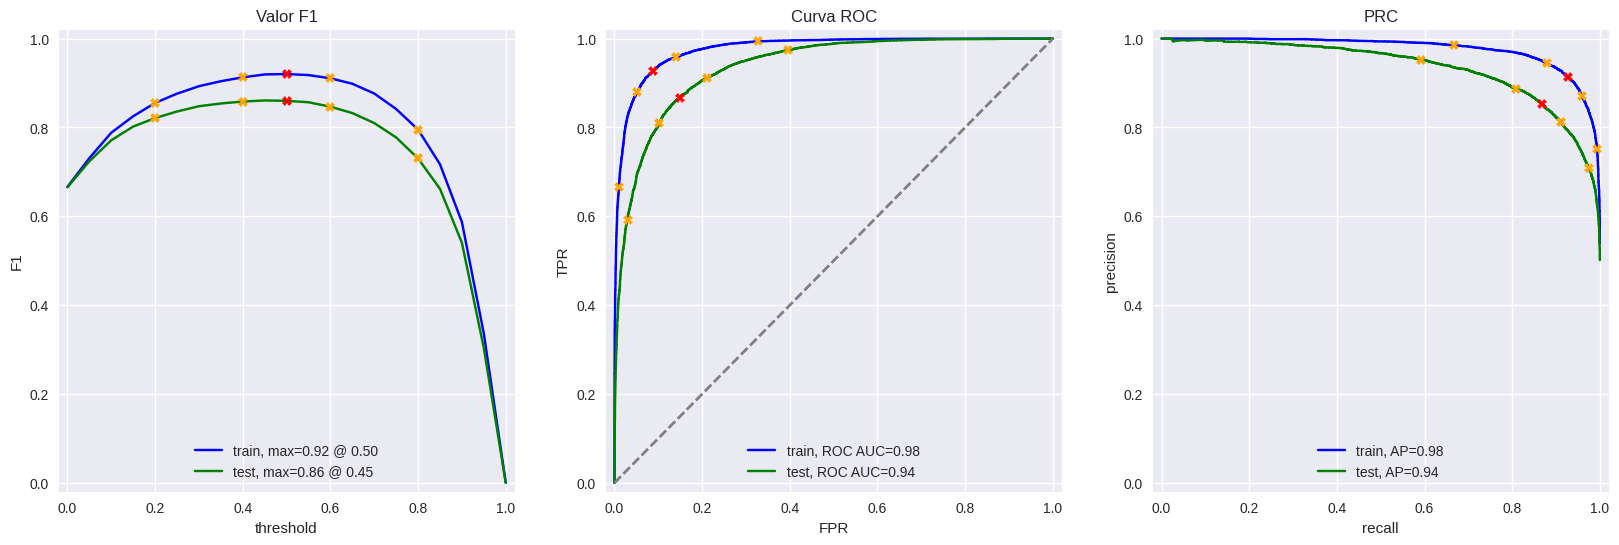

In [37]:
# Evaluar el modelo con la función de evaluación
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


###  Modelo 9 - BERT

In [38]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

Inicializamos el tokenizador, la configuración y el modelo BERT utilizando el pre-entrenamiento bert-base-uncased. Esto significa que estamos utilizando un modelo BERT preentrenado que no distingue entre mayúsculas y minúsculas (uncased), adecuado para muchas tareas de procesamiento del lenguaje natural (NLP).

In [39]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # texto al id de relleno de tokens junto con sus máscaras de atención 
       
#     for text in texts:
#         encoded_dict = tokenizer.encode_plus(
#             text,                      # Texto a tokenizar.
#             add_special_tokens=True,   # Agregar tokens especiales (CLS y SEP).
#             max_length=max_length,     # Máxima longitud permitida para BERT.
#             padding='max_length',      # Rellenar a la longitud máxima.
#             truncation=True,           # Truncar a la longitud máxima si es necesario.
#             return_attention_mask=True,# Devuelve las máscaras de atención.
#             return_tensors='pt'        # Retorna tensores PyTorch.
#         )
        
#         # Añadir ids de entrada y máscaras de atención a las listas
#         ids_list.append(encoded_dict['input_ids'].flatten().tolist())
#         attention_mask_list.append(encoded_dict['attention_mask'].flatten().tolist())
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Uso del dispositivo {device}.')
    
#     # obtener insertados en lotes
    
#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

# # Guardar el modelo BERT como 'model_9' para uso posterior
# model.save_pretrained('./model_9')

# print("Modelo guardado exitosamente como 'model_9'.")


Creamos una función para convertir los textos en embeddings utilizando BERT. La función realiza tokenización, crea máscaras de atención, y ejecuta inferencia con BERT para generar embeddings.

Para transformar los textos de entrada en embeddings que pueden ser utilizados como características en modelos de clasificación u otras tareas de NLP. Los embeddings generados por BERT contienen información semántica rica y contextual, lo que mejora el desempeño de los modelos de machine learning.

In [40]:
# Aplicar BERT a los datos de entrenamiento (comentado)

# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas

# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')


Llamamos a la función BERT_text_to_embeddings para transformar los textos normalizados del conjunto de entrenamiento en embeddings.

Este paso es crucial para preparar los datos antes del entrenamiento del modelo. Al utilizar los embeddings generados por BERT, estamos utilizando una representación densa y significativa de los textos, lo cual mejora la capacidad del modelo para aprender patrones complejos.

In [41]:
# Comprobar formas de las características y objetivos de entrenamiento (comentado)

# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)


In [42]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

Incluimos código (comentado) para guardar los embeddings generados en un archivo comprimido y para cargarlos posteriormente.

Generar embeddings con BERT es una operación intensiva en términos de tiempo y recursos computacionales. Guardar los resultados permite reutilizarlos sin necesidad de recalcularlos, optimizando así el flujo de trabajo. Comentar estos bloques de código sirve como una guía para guardar/cargar los embeddings en futuras ejecuciones, evitando recomputaciones innecesarias y ahorrando tiempo y recursos.

#### Por qué comentamos partes del código?

1. Uso de recursos:

 Ejecutar el modelo BERT para miles de textos puede ser muy costoso en términos de recursos computacionales (CPU, RAM, GPU). En muchas plataformas, especialmente en ambientes de desarrollo limitados (como algunos servicios de notebooks en la nube), ejecutar este proceso puede no ser factible o puede llevar demasiado tiempo.
 
2. Documentación y Claridad:

 Comentar partes del código nos permite documentar explícitamente qué pasos seguir en ambientes más potentes o en el futuro cuando los recursos sean más accesibles. Es una guía paso a paso de lo que se debe hacer cuando se quiere completar el flujo de trabajo de principio a fin con BERT.
 
3. Flexibilidad para el Usuario: 

 Al dejar estos pasos documentados, se le proporciona a otros usuarios o futuros desarrolladores del proyecto la flexibilidad de seguir el proceso completo cuando sea necesario y con los recursos adecuados, sin perder la comprensión del contexto o los detalles del flujo de trabajo.

## Mis reseñas

In [43]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


In [44]:
my_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review       8 non-null      object
 1   review_norm  8 non-null      object
dtypes: object(2)
memory usage: 256.0+ bytes


### Modelo 2

In [45]:
# Cargar el modelo entrenado
model_1 = joblib.load('model_1.pkl')

# Cargar el vectorizador TF-IDF
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Transformar las reseñas normalizadas usando el vectorizador TF-IDF cargado
my_reviews_features_2 = tfidf_vectorizer.transform(my_reviews['review_norm'])

# Realizar predicciones en nuevas reseñas
my_reviews_pred_prob = model_1.predict_proba(my_reviews_features_2)[:, 1]

# Imprimir resultados
for i, review in enumerate(my_reviews['review']):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')


0.16: I did not simply like it, not my kind of movie.
0.18: Well, I was bored and felt asleep in the middle of the movie.
0.56: I was really fascinated with the movie
0.13: Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.26: I didn't expect the reboot to be so good! Writers really cared about the source material
0.48: The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.05: What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.84: Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.


### Modelo 3

In [46]:
# Cargar el modelo y el vectorizador
model_3 = joblib.load('model_3.pkl')

tfidf_vectorizer_3 = joblib.load('tfidf_vectorizer_3.pkl')

# Cargar el modelo de spaCy para el preprocesamiento
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Preprocesar el texto
my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_3)

# Transformar las características textuales
texts_transformed_spacy = tfidf_vectorizer_3.transform(my_reviews['review_norm'])

# Realizar predicciones
my_reviews_pred_prob = model_3.predict_proba(texts_transformed_spacy)[:, 1]

# Mostrar resultados
for i, review in enumerate(my_reviews['review']):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.15:  I did not simply like it, not my kind of movie.
0.20:  Well, I was bored and felt asleep in the middle of the movie.
0.50:  I was really fascinated with the movie
0.19:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.19:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.68:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.03:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.87:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.


### Modelo 4

In [47]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_4
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_4(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  I do not simply like it , not my kind of movie .
0.45:  well , I be bored and feel asleep in the middle of the movie .
0.60:  I be really fascinated with the movie
0.61:  even the actor look really old and disinterested , and they get pay to be in the movie . what a soul
0.43:  I do not expect the reboot to be so good ! writer really care about the source material
0.79:  the movie have its upside and downside , but I feel like overall it be a decent flick . I could see 
0.17:  what a rotten attempt at a comedy . not a single joke land , everyone act annoying and loud , even k
0.76:  launch on Netflix be a brave move & I really appreciate be able to binge on episode after episode , 


### Modelo 9

In [48]:

# texts = df_reviews_train['review_norm']
# labels = df_reviews_train['label']  # Asumiendo que tienes una columna con las etiquetas

# # Paso 1: Obtener los embeddings de BERT
# train_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# # Paso 2: Dividir los datos en conjunto de entrenamiento y validación
# X_train, X_val, y_train, y_val = train_test_split(train_features_9, labels, test_size=0.2, random_state=42)

# # Paso 3: Entrenar el modelo de regresión logística
# model_9 = LogisticRegression(max_iter=1000)
# model_9.fit(X_train, y_train)

# # Paso 4: Evaluar el modelo (opcional)
# val_accuracy = model_9.score(X_val, y_val)
# print(f'Accuracy en validación: {val_accuracy:.2f}')

# # Paso 5: Guardar el modelo entrenado
# joblib.dump(model_9, './model_9.pkl')


In [49]:
# # Paso 3: Cargar tu modelo de regresión logística preentrenado
# model_9 = joblib.load('model_3.pkl')

# # Paso 4: Obtener las características usando BERT
# texts = my_reviews['review_norm']
# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# # Paso 5: Hacer predicciones con el modelo de regresión logística
# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# # Paso 6: Imprimir las predicciones
# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

- Analisis de resultados

 En este proyecto, se evaluaron tres modelos para la clasificación de sentimientos en reseñas de películas, utilizando una escala de 0 a 1, donde 0 indica un sentimiento negativo y 1 un sentimiento positivo. A continuación, se describen los resultados obtenidos por cada modelo:
 
- Modelo 2: 
 
 Los resultados varían de 0.05 a 0.84, con una precisión general aceptable.
 
 
 Algunas reseñas claramente negativas, como "What a rotten attempt at a comedy," fueron correctamente clasificadas con un puntaje muy bajo (0.05).
 
 
 Sin embargo, hay una cierta inconsistencia en la clasificación de reseñas con sentimientos mixtos o matizados, como "The movie had its upsides and downsides," que obtuvo un 0.48, lo que sugiere una comprensión parcial del sentimiento.
 
- Modelo 3:

 Este modelo muestra una mejora notable en la coherencia de las clasificaciones, con puntajes que van desde 0.03 a 0.87.
 
 
 Las reseñas que expresan sentimientos mixtos están mejor diferenciadas, como en el caso de "The movie had its upsides and downsides," que recibió un 0.68, reflejando un balance entre aspectos positivos y negativos.
 
 
 Las reseñas positivas son identificadas con mayor claridad, como se observa en "Launching on Netflix was a brave move," que recibió un puntaje de 0.87.
 
- Modelo 4:

 Este modelo presenta una mayor variabilidad en los resultados, con puntajes que oscilan entre 0.17 y 0.79.
 
 
Aunque las reseñas claramente positivas o negativas son reconocidas adecuadamente, se observa una tendencia a sobreestimar los sentimientos en reseñas negativas o mixtas, lo que podría indicar un sesgo hacia clasificaciones más positivas.


Por ejemplo, la reseña "Even the actors looked really old and disinterested," que es claramente negativa, fue clasificada con un 0.61, lo que no corresponde al sentimiento expresado.

- Conclusion

 Al comparar los tres modelos, el Modelo 3 demostró ser el más equilibrado y preciso en la clasificación de sentimientos, logrando una mejor diferenciación entre reseñas positivas, negativas y mixtas.
 
 Aunque el Modelo 2 también mostró buenos resultados, su inconsistencia en la clasificación de sentimientos matizados lo coloca por detrás del Modelo 3. El Modelo 4, aunque mostró alguna precisión en ciertos casos, presentó una tendencia a clasificar reseñas negativas como más positivas de lo que realmente son, lo que reduce su fiabilidad.

En resumen, el Modelo 3 se destaca como la mejor opción para la clasificación de sentimientos en este contexto, proporcionando resultados más coherentes y alineados con el contenido de las reseñas. Este modelo podría ser una base sólida para futuras aplicaciones en análisis de sentimientos en textos.

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 